# Atari mit DQN

## Aufgabe 4
Löse das PongNoFrameskip-v4 Environment mittels DQN.

In [1]:
%run ../setup.ipynb

In [2]:
import time
from datetime import datetime
import numpy as np
from contextlib import suppress
from lib.loggers import TensorBoardLogger, tf_summary_image

def interact_with_environment(env, agent, n_episodes=600, max_steps=1000000, train=True, verbose=True):      
    statistics = []
    tb_logger = TensorBoardLogger(f'./logs/run-{datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}')
    
    with suppress(KeyboardInterrupt):
        total_step = 0
        for episode in range(n_episodes):
            done = False
            episode_reward = 0
            state = env.reset()
            episode_start_time = time.time()
            episode_step = 0

            while not done:
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)

                if train:
                    agent.train((state, action, next_state, reward, done))

                if episode == 0:
                    # for debug purpose log every state of first episode
                    for obs in state:
                        tb_logger.log_image(f'state_t{episode_step}:', tf_summary_image(np.array(obs, copy=False)),
                                            global_step=total_step)
                state = next_state
                episode_reward += reward
                episode_step += 1
            
            total_step += episode_step

            if episode % 10 == 0:
                speed = episode_step / (time.time() - episode_start_time)
                tb_logger.log_scalar('score', episode_reward, global_step=total_step)
                tb_logger.log_scalar('epsilon', agent.epsilon, global_step=total_step)
                tb_logger.log_scalar('speed', speed, global_step=total_step)
                if verbose:
                    print(f'episode: {episode}/{n_episodes}, score: {episode_reward}, steps: {episode_step}, '
                          f'total steps: {total_step}, e: {agent.epsilon:.3f}, speed: {speed:.2f} steps/s')

            statistics.append({
                'episode': episode,
                'score': episode_reward,
                'steps': episode_step
            })
                                  
            if total_step >= max_steps:
                break
        
    return statistics

### 4.1
Implementiere in **agent.py** einen Agenten, der in der Lage ist das Environment zu lösen.

NoopResetEnv (max 30) wrapper is used.
MaxAndSkipEnv wrapper is used.
EpisodicLifeEnv wrapper is used.
FireResetEnv wrapper is used.
ClipRewardEnv wrapper is used.
FrameStack (4) wrapper is used.
episode: 0/600, score: -21.0, steps: 818, total steps: 818, e: 1.000, speed: 380.85 steps/s
episode: 10/600, score: -20.0, steps: 922, total steps: 9909, e: 1.000, speed: 759.17 steps/s
episode: 20/600, score: -19.0, steps: 991, total steps: 18532, e: 0.916, speed: 135.45 steps/s
episode: 30/600, score: -19.0, steps: 975, total steps: 27458, e: 0.827, speed: 130.48 steps/s
episode: 40/600, score: -20.0, steps: 898, total steps: 36787, e: 0.735, speed: 126.40 steps/s
episode: 50/600, score: -19.0, steps: 1111, total steps: 46797, e: 0.636, speed: 117.09 steps/s
episode: 60/600, score: -16.0, steps: 1565, total steps: 57321, e: 0.532, speed: 103.86 steps/s
episode: 70/600, score: -21.0, steps: 956, total steps: 67530, e: 0.430, speed: 115.47 steps/s


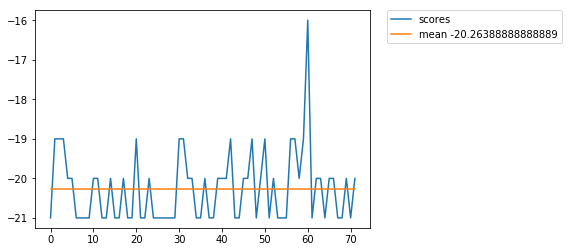

In [7]:
import gym
from lib.statistics import plot
from lib.atari_helpers import wrap_deepmind, make_atari
from agent import AtariDQN
from tensorflow.keras.backend import set_session
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

env = make_atari('PongNoFrameskip-v4')
env = wrap_deepmind(env, frame_stack=True)

action_size = env.action_space.n
state_size = env.observation_space.shape[0]

# Hyperparams
annealing_steps = 100000  # not episodes!
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = (epsilon - epsilon_min) / annealing_steps
alpha = 0.0001
batch_size = 64
memory_size = 10000
start_replay_step = 10000
target_model_update_interval = 1000
train_freq = 4

agent = AtariDQN(action_size=action_size, state_size=state_size, gamma=gamma, 
                 epsilon=epsilon, epsilon_decay=epsilon_decay, epsilon_min=epsilon_min, 
                 alpha=alpha, batch_size=batch_size, memory_size=memory_size,
                 start_replay_step=start_replay_step, 
                 target_model_update_interval=target_model_update_interval, train_freq=train_freq)
statistics = interact_with_environment(env, agent, verbose=True)
env.close()
plot(statistics)

In [ ]:
from gym.wrappers import Monitor
from lib.atari_helpers import wrap_deepmind, make_atari
from lib.statistics import html_video_embedding

# capture every episode and clean 'video' folder before each run
env = make_atari('PongNoFrameskip-v4')
env = Monitor(env, './video', video_callable=lambda episode_id: True, force=True, uid='id')
env = wrap_deepmind(env, frame_stack=True)
statistics = interact_with_environment(env, agent, n_episodes=10, train=False, verbose=False)
env.close()

plot(statistics, y_limits=(-21,21))
html_video_embedding(statistics)